In [ ]:
from datasets import load_dataset

dataset = load_dataset("FrankCCCCC/colored_mnist_28")

In [2]:
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import random
import json

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class ColoredMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(np.array(self.images[idx]))
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Organize images by class
class_to_images = {}
for example in dataset['train']:
    label = example['label']
    if label not in class_to_images:
        class_to_images[label] = []
    class_to_images[label].append(example['image'])

# Load the saved indices
with open("subsets_indices.json", "r") as f:
    subset_indices = json.load(f)

# Reconstruct subsets
loaded_subsets = {}
for key, indices in subset_indices.items():
    images_subset = [dataset['train'][idx]['image'] for idx in indices]
    labels_subset = [dataset['train'][idx]['label'] for idx in indices]
    
    loaded_subsets[int(key)] = ColoredMNISTDataset(
        images_subset, labels_subset, transform=transform
    )

# Example: check number of images
for key, subset in loaded_subsets.items():
    print(f"Loaded Subset {key} (classes {list(range(key))}): {len(subset)} images")


Loaded Subset 1 (classes [0]): 434 images
Loaded Subset 2 (classes [0, 1]): 934 images
Loaded Subset 3 (classes [0, 1, 2]): 1363 images
Loaded Subset 4 (classes [0, 1, 2, 3]): 1817 images
Loaded Subset 5 (classes [0, 1, 2, 3, 4]): 2258 images
Loaded Subset 6 (classes [0, 1, 2, 3, 4, 5]): 2640 images
Loaded Subset 7 (classes [0, 1, 2, 3, 4, 5, 6]): 3086 images
Loaded Subset 8 (classes [0, 1, 2, 3, 4, 5, 6, 7]): 3560 images
Loaded Subset 9 (classes [0, 1, 2, 3, 4, 5, 6, 7, 8]): 3977 images
Loaded Subset 10 (classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]): 4415 images


In [ ]:
from torchvision import models
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet.eval()
resnet.to(device)  

def extract_embeddings(dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.cuda()
            features = resnet(images)
            embeddings.append(features.cpu().numpy())
    return np.concatenate(embeddings, axis=0)

In [ ]:
from torch.utils.data import DataLoader

dataloaders = {i: DataLoader(subset, batch_size=32, shuffle=False) for i, subset in loaded_subsets.items()}

embeddings = {}
for i, dataloader in dataloaders.items():
    embeddings[i] = extract_embeddings(dataloader)

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

distance_matrices = {}

for key, emb in embeddings.items():

    dist_matrix = cdist(emb, emb, metric='cosine')
    distance_matrices[key] = dist_matrix
    print(f"Subset {key}: distance matrix shape {dist_matrix.shape}")

Subset 1: distance matrix shape (434, 434)
Subset 2: distance matrix shape (934, 934)
Subset 3: distance matrix shape (1363, 1363)
Subset 4: distance matrix shape (1817, 1817)
Subset 5: distance matrix shape (2258, 2258)
Subset 6: distance matrix shape (2640, 2640)
Subset 7: distance matrix shape (3086, 3086)
Subset 8: distance matrix shape (3560, 3560)
Subset 9: distance matrix shape (3977, 3977)
Subset 10: distance matrix shape (4415, 4415)


In [6]:
import numpy as np

from PLDiv import compute_PLDiv

import time
from magnipy.diversipy import Diversipy


In [7]:
start_time = time.time() 

pldiv = np.array([
    compute_PLDiv(d, hom_deg=0, distance_matrix= True, sparse=None, closed_form=False)   # without sparse matrix optimization
    for d in distance_matrices.values()
])

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 23.826 seconds


In [8]:
from vendi_score import data_utils, vendi
def embedding_vendi_score(
    X, batch_size=64, device="cpu", model=None, transform=None, normalize = True
):
    n, d = X.shape
    if n < d:
        return vendi.score_X(X, normalize = True)
    return vendi.score_dual(X, normalize = True)

In [9]:
start_time = time.time() 

vs_emb = []
for k, emb in embeddings.items():
    vs_ = embedding_vendi_score(emb, normalize = True)
    vs_emb.append(vs_)
    print(vs_)

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

1.8210405
2.084813
2.1132624
2.1154594
2.1079035
2.0948484
2.081437
2.083023
2.0731
2.0554395
Runtime: 5.041 seconds


In [10]:
from sklearn import preprocessing
import torch

def calculate_dcscore_by_embedding(embeddings_arr, kernel_type='cs', tau=1):
    if kernel_type == 'cs':
        # cosine similarity as teh kernel function
        # embeddings_arr = preprocessing.normalize(embeddings_arr, axis=1)
        sim_product = torch.from_numpy((embeddings_arr @ embeddings_arr.T) / tau)
        sim_probs = sim_product.softmax(dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'rbf':
        sim_mat = rbf_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'lap':
        sim_mat = laplacian_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'poly':
        sim_mat = polynomial_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    
    return diversity.item()

In [11]:
start_time = time.time() 

ds_emb = []
for k, emb in embeddings.items():
    dsc_ = calculate_dcscore_by_embedding(emb)
    ds_emb.append(dsc_)
    print(dsc_)

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

15.587090492248535
21.116193771362305
25.213443756103516
36.60337829589844
32.45976257324219
31.29877281188965
40.41207504272461
33.707489013671875
41.860939025878906
44.19370651245117
Runtime: 1.104 seconds


In [12]:
start_time = time.time() 

from magnipy.diversipy import Diversipy
div = Diversipy(Xs = [emb for emb in embeddings.values()],  ref_space=0, metric="cosine")
mag_areas = div.MagAreas()

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Out of the 934 observations in X, only 933 are unique.
Out of the 1363 observations in X, only 1362 are unique.
Out of the 1817 observations in X, only 1816 are unique.
Out of the 2258 observations in X, only 2256 are unique.
Out of the 3086 observations in X, only 3085 are unique.
Out of the 3560 observations in X, only 3558 are unique.
Out of the 3977 observations in X, only 3976 are unique.
Out of the 934 observations in X, only 933 are unique.
Out of the 1363 observations in X, only 1362 are unique.
Out of the 1817 observations in X, only 1816 are unique.
Out of the 2258 observations in X, only 2256 are unique.
Out of the 3086 observations in X, only 3085 are unique.
Out of the 3560 observations in X, only 3558 are unique.
Out of the 3977 observations in X, only 3976 are unique.
Runtime: 219.017 seconds


In [13]:
mag = np.array(mag_areas)
mag

array([ 224.52069842,  413.88412446,  639.10147539,  835.64467346,
       1013.71998632, 1155.51996956, 1327.27839183, 1531.64743919,
       1653.0631013 , 1772.2828787 ])

In [14]:
import pandas as pd
df_results = pd.DataFrame([pldiv, vs_emb, ds_emb, mag])

In [15]:
df_results.columns = np.arange(1, 11)
df_results.index = ['PLDiv', 'VS', 'DSC', 'MAG']
df_results

,1,2,3,4,5,6,7,8,9,10
PLDiv,0.034288,0.054483,0.097018,0.131958,0.162613,0.190668,0.222860,0.252757,0.281662,0.301484
VS,1.821041,2.084813,2.113262,2.115459,2.107903,2.094848,2.081437,2.083023,2.073100,2.055439
DSC,15.587090,21.116194,25.213444,36.603378,32.459763,31.298773,40.412075,33.707489,41.860939,44.193707
MAG,224.520698,413.884124,639.101475,835.644673,1013.719986,1155.519970,1327.278392,1531.647439,1653.063101,1772.282879


In [ ]:
from scipy.stats import spearmanr, pearsonr
import numpy as np

vector = np.arange(1, 11)

for i in range(4):
    row1 = df_results.iloc[i].values
    print(df_results.index[i])

    # Compute correlations
    pearson_corr, _ = pearsonr(row1, vector)
    spearman_corr, _ = spearmanr(row1, vector)

    print(pearson_corr, spearman_corr)

PLDiv


0.9981042605426462 0.9999999999999999
VS
0.3711817071478637 -0.309090909090909
DSC
0.9006388710725711 0.8909090909090909
MAG
0.9972183872167808 0.9999999999999999


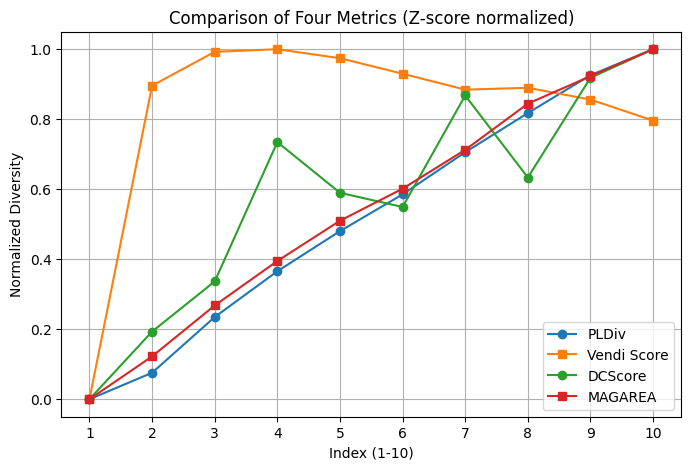

In [20]:
import matplotlib.pyplot as plt

x = np.arange(1, 11)

# Min-max normalization to [0, 1]
vec1_norm = (pldiv - np.min(pldiv)) / (np.max(pldiv) - np.min(pldiv))
vec2_norm = (vs_emb - np.min(vs_emb)) / (np.max(vs_emb) - np.min(vs_emb))
vec3_norm = (ds_emb - np.min(ds_emb)) / (np.max(ds_emb) - np.min(ds_emb))
vec4_norm = (mag - np.min(mag)) / (np.max(mag) - np.min(mag))

plt.figure(figsize=(8, 5))
plt.plot(x, vec1_norm, marker='o', label='PLDiv')
plt.plot(x, vec2_norm, marker='s', label='Vendi Score')
plt.plot(x, vec3_norm, marker='o', label='DCScore')
plt.plot(x, vec4_norm, marker='s', label='MAGAREA')

plt.xlabel('Index (1-10)')
plt.ylabel('Normalized Diversity')
plt.title('Comparison of Four Metrics (Z-score normalized)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()